In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_merge_data(customers_path, transactions_path):
    customers = pd.read_csv(customers_path)
    transactions = pd.read_csv(transactions_path)

    customer_transactions = pd.merge(transactions, customers, on='CustomerID', how='left')
    customer_transactions.dropna(inplace=True)

    return customer_transactions


In [7]:
def feature_engineering(customer_transactions):
    customer_transactions['Recency'] = (pd.to_datetime('today') - pd.to_datetime(customer_transactions['TransactionDate'])).dt.days
    customer_transactions['Monetary'] = customer_transactions['TotalValue']
    customer_transactions['Frequency'] = customer_transactions.groupby('CustomerID')['TransactionID'].transform('count')
    rfm_table = customer_transactions.groupby('CustomerID').agg({
        'Recency': 'min',
        'Frequency': 'max',
        'Monetary': 'sum'
    }).reset_index()

    return rfm_table

In [8]:
def preprocess_data(rfm_table):
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(rfm_table[['Recency', 'Frequency', 'Monetary']])
    return features_scaled


In [9]:
def dbscan_clustering(features_scaled, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(features_scaled)
    return labels

In [10]:
def agglomerative_clustering(features_scaled, num_clusters=5):
    agg = AgglomerativeClustering(n_clusters=num_clusters)
    labels = agg.fit_predict(features_scaled)
    return labels

In [19]:
def evaluate_clustering(features_scaled, labels):
    db_index = davies_bouldin_score(features_scaled, labels)
    silhouette = silhouette_score(features_scaled, labels)
    return db_index, silhouette


In [20]:
def visualize_clusters(features_scaled, labels):
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features_scaled)

    plt.figure(figsize=(8,6))
    sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=labels, palette='viridis', alpha=0.6)
    plt.title('Customer Segmentation using Clustering')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend()
    plt.show()


Davies-Bouldin Index: 0.9792778868316254, Silhouette Score: 0.3160245213223076


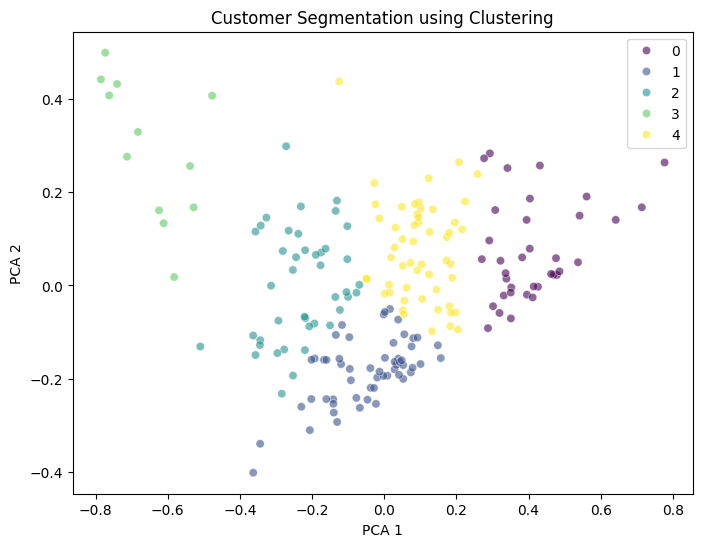

In [27]:
def customer_segmentation(customers_path, transactions_path, clustering_algorithm='KMeans', num_clusters=5):
    customer_transactions = load_and_merge_data(customers_path, transactions_path)
    rfm_table = feature_engineering(customer_transactions)
    features_scaled = preprocess_data(rfm_table)
    if clustering_algorithm == 'KMeans':
        kmeans, labels = kmeans_clustering(features_scaled, num_clusters)
    elif clustering_algorithm == 'DBSCAN':
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        labels = dbscan.fit_predict(features_scaled)
        unique_labels = len(set(labels))
        if unique_labels < 2:
            print("Warning: DBSCAN identified less than two clusters.")
            return None, None, None
        labels = dbscan_clustering(features_scaled)
    elif clustering_algorithm == 'Agglomerative':
        labels = kmeans_clustering(features_scaled, num_clusters) # Replace
        labels = agglomerative_clustering(features_scaled, num_clusters)
    db_index, silhouette = evaluate_clustering(features_scaled, labels)
    print(f'Davies-Bouldin Index: {db_index}, Silhouette Score: {silhouette}')
    visualize_clusters(features_scaled, labels)

    return labels, db_index, silhouette
customers_path = 'Customers.csv'
transactions_path = 'Transactions.csv'
clustering_algorithm = 'KMeans'
labels, db_index, silhouette = customer_segmentation(customers_path, transactions_path, clustering_algorithm)